<a href="https://colab.research.google.com/github/redrabbit329/-Edge-AI-Platform-Tutorials/blob/master/rr___Brain_Tumor_MobileNet_OpenCV_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D 
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
import math

# root dir
# data root dir
# train data root dir
# test data root dir

In [2]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

# Google Drive 마운트해서 데이터셋 가져옴

In [3]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


In [4]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    
    shutil.copy(os.path.join(dataset_path, 'brain_tumor.zip'), '/content')

except Exception as err:
    print(str(err))

In [5]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
    
    shutil.rmtree(DATA_ROOT_DIR)
    
    print(DATA_ROOT_DIR + ' is removed !!!')

In [6]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'brain_tumor.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR) 

# brain_tumor/Testing 확인
# brain_tumor/Training 확인

In [7]:
import os

#========================================================
# train 정답 및 전체 데이터 개수 확인
#========================================================

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#========================================================
# test 정답 및 전체 데이터 개수 확인
#========================================================

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:

    print('test label : ', label_name, ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
train label :  glioma_tumor  =>  826
train label :  meningioma_tumor  =>  822
train label :  pituitary_tumor  =>  827
train label :  no_tumor  =>  395
['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
test label :  glioma_tumor  =>  100
test label :  meningioma_tumor  =>  115
test label :  pituitary_tumor  =>  74
test label :  no_tumor  =>  105


# Testing 디렉토리 모든 파일을 Training 동일 디렉토리로 move

In [8]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:  # Testing 디렉토리 각각의 label 에서 실행

    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    moved_num = 0

    for test_image_file in test_file_list:  # Testing 모든 data를 Training 디렉토리로 이동

        # already exists error 방지
        # 참고소스: https://stackoverflow.com/questions/31813504
        shutil.move(os.path.join(test_path, test_image_file),
                    os.path.join(train_path, test_image_file))

        moved_num = moved_num + 1

    print(str(moved_num) + ' is moved into ' + label_name + ' (Testing => Training)')

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
100 is moved into glioma_tumor (Testing => Training)
115 is moved into meningioma_tumor (Testing => Training)
74 is moved into pituitary_tumor (Testing => Training)
105 is moved into no_tumor (Testing => Training)


# 전체 데이터 개수가 많지 않으므로 x_train, x_test 직접 생성함
### move 완료된 train 전체 데이터 개수 확인

In [9]:
#========================================================
# train 정답 및 전체 데이터 개수 확인
#========================================================

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
train label :  glioma_tumor  =>  926
train label :  meningioma_tumor  =>  937
train label :  pituitary_tumor  =>  901
train label :  no_tumor  =>  396


# 이미지 shape 설정

In [10]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# OpenCV 이용해서 이미지 로드

In [11]:
train_data_list = []
train_label_list = []

class_dict = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [19]:
import os
import cv2
import glob
import numpy as np
from datetime import datetime

image_label_list = os.listdir(TRAIN_DATA_ROOT_DIR)    # 정답이름

# 모든 이미지 파일에 대해서
for label_name in image_label_list:

    # 이미지 파일 읽어오기

    file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    img_file_list = glob.glob(file_path+'/*.jpg')

    # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 .jpg 파일 읽어서 리스트에 저장
    
    width_list = []
    height_list = []
    for img_file in img_file_list:

        try:
            src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) 

            # 
            #print(type(src_img), src_img.shape)
            # 원본 이미지를 read해 온 다음에, 원본 이미지의 크기가 얼마인지 확인할 필요가 있어 보임
            # 
            # print(src_img.shape[0])
            # list_img_size += [src_img.shape[0]]

            # 모든 이미지에 대한 W, H를 차곡차곡 리스트에 저장한다.
            width_list.append(src_img.shape[0])
            height_list.append(src_img.shape[1])


            src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
            src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

            train_data_list.append(src_img)
            train_label_list.append(float(class_dict[label_name]))  # 정답은 문자열을 실수로 변환

        except Exception as err:
            print(str(err), img_file)
            continue


    width_np = np.array(width_list)
    height_np = np.array(height_list)

    print(label_name, 'width avg = ', np.average(width_np),  ', height avg = ', np.average(height_np))

glioma_tumor width avg =  502.9719222462203 , height avg =  500.74190064794817
meningioma_tumor width avg =  466.24653148345783 , height avg =  461.3212379935966
pituitary_tumor width avg =  516.6426193118757 , height avg =  517.2730299667037
no_tumor width avg =  353.2121212121212 , height avg =  350.16161616161617


In [ ]:
# numpy 변환

x_train = np.array(train_data_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)

x_train.shape =  (3160, 224, 224, 3) , y_train.shape =  (3160,)


# train data 생성 (numpy)
### train_data_list => x_train
### train_label_list => y_train

In [ ]:
x_train = np.array(train_data_list)

y_train = np.array(train_label_list)

print('train_data_numpy.shape = ', x_train.shape)
print('train_label_numpy.shape = ', y_train.shape)

print(y_train[:5])
print(y_train[-5:])

train_data_numpy.shape =  (3160, 224, 224, 3)
train_label_numpy.shape =  (3160,)
[1. 1. 1. 1. 1.]
[3. 3. 3. 3. 3.]


# train 데이터에서 20% 비율만큼 test 데이터 생성

In [ ]:
SPLIT_RATIO = 0.20    # 20 % 비율로 test data 생성

In [ ]:
import numpy as np

SPLIT_NUMS = int(SPLIT_RATIO*len(x_train))

print('split nums => ', SPLIT_NUMS)

#=============================================
# x_train, y_train 동시에 shuffle
#=============================================
s = np.arange(len(x_train))

np.random.shuffle(s)

x_train = x_train[s]

y_train = y_train[s]
#=============================================


# test data 생성
#=============================================
x_test = x_train[:SPLIT_NUMS]
y_test = y_train[:SPLIT_NUMS]

x_train = x_train[SPLIT_NUMS:]
y_train = y_train[SPLIT_NUMS:]
#=============================================

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

split nums =>  632
x_train.shape =  (2528, 224, 224, 3)
y_train.shape =  (2528,)
x_test.shape =  (632, 224, 224, 3)
y_test.shape =  (632,)


# 데이터 정규화

In [ ]:
x_train = x_train.astype(np.float32) / 255.0

x_test = x_test.astype(np.float32) / 255.0

In [ ]:
import random

random_index_list = random.sample( list(range(len(y_train))), 16) 

print(random_index_list)

print(y_train[random_index_list])

[1008, 2455, 37, 1944, 757, 1109, 1856, 837, 930, 2427, 1976, 1848, 1498, 1627, 160, 99]
[2. 3. 1. 0. 3. 1. 2. 3. 0. 1. 0. 2. 3. 0. 1. 0.]


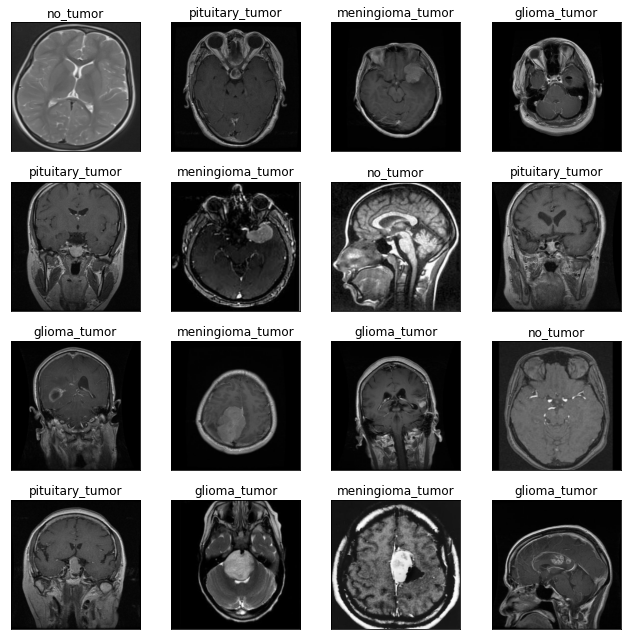

In [ ]:
import matplotlib.pyplot as plt

class_dict = { 0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}

plt.figure(figsize=(9,9))

pos = 0

for i in random_index_list:

    plt.subplot(4, 4, pos+1)
    plt.title(str(class_dict[y_train[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(x_train[i])

    pos += 1

plt.tight_layout()
plt.show()

# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [ ]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

pre_trained_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
class_nums = len(os.listdir(TRAIN_DATA_ROOT_DIR))  # 정답개수

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
                              verbose=1)


start_time = datetime.now()

hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[earlystopping])

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/50
79/79 [==============================] - 29s 201ms/step - loss: 1.7250 - acc: 0.3619 - val_loss: 0.9512 - val_acc: 0.6203
Epoch 2/50
79/79 [==============================] - 15s 189ms/step - loss: 1.1578 - acc: 0.5273 - val_loss: 0.7424 - val_acc: 0.7547
Epoch 3/50
79/79 [==============================] - 15s 187ms/step - loss: 0.8712 - acc: 0.6566 - val_loss: 0.6425 - val_acc: 0.7880
Epoch 4/50
79/79 [==============================] - 15s 189ms/step - loss: 0.7358 - acc: 0.7188 - val_loss: 0.5681 - val_acc: 0.8054
Epoch 5/50
79/79 [==============================] - 15s 192ms/step - loss: 0.6385 - acc: 0.7488 - val_loss: 0.5127 - val_acc: 0.8244
Epoch 6/50
79/79 [==============================] - 15s 191ms/step - loss: 0.5594 - acc: 0.7892 - val_loss: 0.4615 - val_acc: 0.8418
Epoch 7/50
79/79 [==============================] - 15s 194ms/step - loss: 0.4955 - acc: 0.8113 - val_loss: 0.4447 - val_acc: 0.8449
Epoch 8/50
79/79 [==============================] - 16s 200ms/step - 

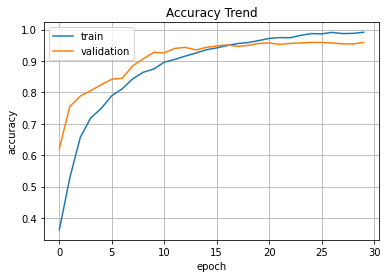

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

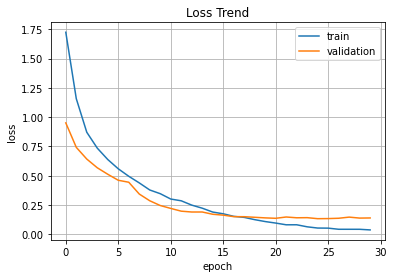

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 40ms/step - loss: 0.1398 - acc: 0.9589


[0.13978512585163116, 0.9588607549667358]